# Post-processing for OPF test cases

In this notebook, we will show how to post-process the results of the OPF test cases. The results are stored in the `results` folder. The model runs are in 2018. 

Includes the following scenarios:

1. Base case without renewable generation, stored in `results/wo_renew`.

2. Cases with renewable generation, stored in `results/w_renew`.

3. Cases with renewable generation and building electrification, stored in `results/w_renew_elec`.


## Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import pickle

plt.rcParams["font.family"] = "Times New Roman"


In [28]:
# Set up directories
cwd = os.getcwd()
if 'examples' in cwd:
    parent_dir = os.path.dirname(cwd)
    data_dir = os.path.join(parent_dir, 'data')
else:
    data_dir = os.path.join(cwd, 'data')

grid_data_dir = os.path.join(data_dir, 'grid')
if not os.path.exists(grid_data_dir):
    raise FileNotFoundError('Grid data directory not found.')

print('Grid data directory: {}'.format(grid_data_dir))

fig_dir = os.path.join(os.path.dirname(data_dir), 'figures')
print('Figure directory: {}'.format(fig_dir))

results_dir = os.path.join(os.path.dirname(data_dir), 'results')
print('Results directory: {}'.format(results_dir))

solar_data_dir = os.path.join(data_dir, 'solar')
print('Solar data directory: {}'.format(solar_data_dir))

onshore_wind_data_dir = os.path.join(data_dir, 'onshore_wind')
print('Onshore wind data directory: {}'.format(onshore_wind_data_dir))

offshore_wind_data_dir = os.path.join(data_dir, 'offshore_wind')
print('Offshore wind data directory: {}'.format(offshore_wind_data_dir))

buildings_data_dir = os.path.join(data_dir, 'buildings')
print('Buildings data directory: {}'.format(buildings_data_dir))

Grid data directory: /home/by276/models/NYgrid-python/data/grid
Figure directory: /home/by276/models/NYgrid-python/figures
Results directory: /home/by276/models/NYgrid-python/results
Solar data directory: /home/by276/models/NYgrid-python/data/solar
Onshore wind data directory: /home/by276/models/NYgrid-python/data/onshore_wind
Offshore wind data directory: /home/by276/models/NYgrid-python/data/offshore_wind
Buildings data directory: /home/by276/models/NYgrid-python/data/buildings


## Read grid data

In [3]:
start_date = datetime(2018, 1, 1, 0, 0, 0)
end_date = datetime(2019, 1, 1, 0, 0, 0)
timestamp_list = pd.date_range(start_date, end_date, freq='1D')

In [4]:
# Read load profile
load_profile = pd.read_csv(os.path.join(grid_data_dir, f'load_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
load_profile.index.freq = 'H'

# Read generation profile
gen_profile = pd.read_csv(os.path.join(grid_data_dir, f'gen_profile_{start_date.year}.csv'), 
                           parse_dates=['TimeStamp'], index_col='TimeStamp')
gen_profile.index.freq = 'H'


## Read OPF results

In [5]:
# Base case without renewable energy
thermal_pg_wo_renew_list = list()
model_wo_renew_list = list()
results_wo_renew_list = list()

# Loop through all days
for d in range(len(timestamp_list)-1):
    # Set up timestamps
    start_datetime = timestamp_list[d]
    end_datetime = start_datetime + timedelta(hours=23)

    # Read thermal generation without renewable energy
    filename = f'thermal_wo_renew_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.csv'
    thermal_pg_wo_renew = pd.read_csv(os.path.join(results_dir, 'wo_renew', filename),
                                      parse_dates=['TimeStamp'], index_col='TimeStamp')
    thermal_pg_wo_renew_list.append(thermal_pg_wo_renew)

    # Read pickle file
    # filename = f'nygrid_sim_wo_renew_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.pkl'
    # with open(os.path.join(results_dir, 'wo_renew', filename), 'rb') as f:
    #     _, model_multi_opf, results = pickle.load(f)
    # model_wo_renew_list.append(model_multi_opf)
    # results_wo_renew_list.append(results)

# Concatenate thermal generation profiles
thermal_pg_wo_renew = pd.concat(thermal_pg_wo_renew_list)


In [6]:
# With renewable energy
results_w_renew_list = list()
thermal_pg_w_renew_list = list()
model_w_renew_list = list()

# Loop through all days
for d in range(len(timestamp_list)-1):
    # Set up timestamps
    start_datetime = timestamp_list[d]
    end_datetime = start_datetime + timedelta(hours=23)
    
    # Read thermal generation with renewable energy
    filename = f'thermal_w_renew_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.csv'
    thermal_pg_w_renew = pd.read_csv(os.path.join(results_dir, 'w_renew', filename),
                                    parse_dates=['TimeStamp'], index_col='TimeStamp')
    thermal_pg_w_renew_list.append(thermal_pg_w_renew)

    # Read pickle file
    # filename = f'nygrid_sim_w_renew_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.pkl'
    # with open(os.path.join(results_dir, 'w_renew', filename), 'rb') as f:
    #     [nygrid_sim, model_multi_opf, results] = pickle.load(f)
    # model_w_renew_list.append(model_multi_opf)
    # results_w_renew_list.append(results)

# Concatenate thermal generation profiles
thermal_pg_w_renew = pd.concat(thermal_pg_w_renew_list)
thermal_pg_w_renew.head()

,59 St. GT 1,74 St. GT 1,74 St. GT 2,Allegany,Allied Frozen Storage,Arthur Kill Cogen,Arthur Kill GT 1,Arthur Kill ST 2,Arthur Kill ST 3,Astoria 2,...,St. Elizabeth Medical Center,Sterling,Stony Brook (BTM:NG),Syracuse,Vernon Blvd 2,Vernon Blvd 3,Wading River 1,Wading River 2,Wading River 3,West Babylon 4
TimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,0.0,0.0,0.0,66.0,0.1,11.1,0.0,349.000000,539.000000,1.0,...,0.6,43.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-01-01 01:00:00,0.0,0.0,0.0,66.0,0.1,0.0,0.0,349.000000,90.053951,1.0,...,0.6,43.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-01-01 02:00:00,0.0,0.0,0.0,66.0,0.1,0.0,0.0,287.748987,1.000000,1.0,...,0.6,37.5,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-01-01 03:00:00,0.0,0.0,0.0,66.0,0.1,0.0,0.0,96.000000,1.000000,1.0,...,0.6,15.0,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0
2018-01-01 04:00:00,0.0,0.0,0.0,66.0,0.1,0.0,0.0,96.000000,1.000000,1.0,...,0.6,20.5,30.0,102.0,18.5,15.0,9.0,7.8,4.0,3.0


In [7]:
# With renewable energy
results_w_renew_elec_list = list()
thermal_pg_w_renew_elec_list = list()
model_w_renew_elec_list = list()

# Loop through all days
for d in range(len(timestamp_list)-1):
    # Set up timestamps
    start_datetime = timestamp_list[d]
    end_datetime = start_datetime + timedelta(hours=23)
    
    # Read thermal generation with renewable energy
    filename = f'thermal_w_renew_elec_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.csv'
    thermal_pg_w_renew_elec = pd.read_csv(os.path.join(results_dir, 'w_renew_elec', filename),
                                    parse_dates=['TimeStamp'], index_col='TimeStamp')
    thermal_pg_w_renew_elec_list.append(thermal_pg_w_renew_elec)

    # Read pickle file
    # filename = f'nygrid_sim_w_renew_elec_{start_datetime.strftime("%Y%m%d%H")}_{end_datetime.strftime("%Y%m%d%H")}.pkl'
    # with open(os.path.join(results_dir, 'w_renew_elec', filename), 'rb') as f:
    #     [nygrid_sim, model_multi_opf, results] = pickle.load(f)
    # model_w_renew_elec_list.append(model_multi_opf)
    # results_w_renew_elec_list.append(results)

# Concatenate thermal generation profiles
thermal_pg_w_renew_elec = pd.concat(thermal_pg_w_renew_elec_list)

In [8]:
# Save to csv
thermal_pg_wo_renew.to_csv(os.path.join(results_dir, 'thermal_pg_wo_renew.csv'))
thermal_pg_w_renew.to_csv(os.path.join(results_dir, 'thermal_pg_w_renew.csv'))
thermal_pg_w_renew_elec.to_csv(os.path.join(results_dir, 'thermal_pg_w_renew_elec.csv'))

## Calculate heat input

In [9]:
# Read thermal generator info table
filename = os.path.join(data_dir, 'genInfo.csv')
gen_info = pd.read_csv(filename)
num_thermal = gen_info.shape[0]
gen_rename = {gen_info.index[i]: gen_info.NYISOName[i] for i in range(num_thermal)}
gen_info

,NYISOName,PTID,Zone,UnitType,FuelType,Latitude,Longitude,maxPower,minPower,maxRampAgc,...,maxRamp60,HeatRateLM_1,HeatRateLM_0,HeatRateLM_R2,HeatRateQM_2,HeatRateQM_1,HeatRateQM_0,HeatRateQM_R2,useQM,start-time
0,59 St. GT 1,24138,J,Combustion Turbine,Kerosene,40.772385,-73.993028,17.1,0.0,1.710000,...,17.1,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
1,74 St. GT 1,24260,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
2,74 St. GT 2,24261,J,Combustion Turbine,Kerosene,40.768421,-73.951731,18.5,0.0,1.850000,...,18.5,13.315000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
3,Allegany,23514,B,Combined Cycle,Natural Gas,42.508300,-78.066100,66.0,11.0,6.600000,...,66.0,8.218122,-14.577671,0.862443,-0.094773,15.209040,-125.857658,0.891407,1,10m
4,Allied Frozen Storage,23774,A,Internal Combustion,Natural Gas,42.842029,-78.722673,0.1,0.0,0.010000,...,0.1,8.899000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,10m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,Vernon Blvd 3,24163,J,Combustion Turbine,Natural Gas,40.753900,-73.950600,42.0,15.0,0.558333,...,33.5,17.272897,-319.572736,0.893510,0.524043,-14.979198,132.238854,0.935802,1,over
223,Wading River 1,23522,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,102.0,9.0,1.258333,...,75.5,12.779330,-5.232355,0.960069,-0.051615,18.026301,-96.225639,0.967170,1,over
224,Wading River 2,23547,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,7.8,1.350000,...,81.0,13.381103,-32.778267,0.981323,-0.027035,15.957351,-73.206752,0.982889,1,over
225,Wading River 3,23601,K,Combustion Turbine,Fuel Oil 2,40.956900,-72.877400,94.0,4.0,1.333333,...,80.0,12.154083,-11.601042,0.822005,-0.022269,14.190789,-39.250293,0.821057,1,over


In [11]:
# Heat input linear model
heat_rate_lm = gen_info[['HeatRateLM_1', 'HeatRateLM_0']].to_numpy()

heat_input_wo_renew = pd.DataFrame(index=thermal_pg_wo_renew.index)
heat_input_w_renew = pd.DataFrame(index=thermal_pg_w_renew.index)
heat_input_w_renew_elec = pd.DataFrame(index=thermal_pg_w_renew_elec.index)

# Loop through all thermal generators
for i in range(num_thermal):
    # Get heat rate linear model
    heat_rate_lm_i = heat_rate_lm[i, :]
    
    # Get thermal generation profiles
    thermal_pg_wo_renew_i = thermal_pg_wo_renew[gen_rename[i]]
    thermal_pg_w_renew_i = thermal_pg_w_renew[gen_rename[i]]
    thermal_pg_w_renew_elec_i = thermal_pg_w_renew_elec[gen_rename[i]]
    
    # Get heat input
    heat_input_wo_renew_i = heat_rate_lm_i[0] * thermal_pg_wo_renew_i + heat_rate_lm_i[1]
    heat_input_w_renew_i = heat_rate_lm_i[0] * thermal_pg_w_renew_i + heat_rate_lm_i[1]
    heat_input_w_renew_elec_i = heat_rate_lm_i[0] * thermal_pg_w_renew_elec_i + heat_rate_lm_i[1]

    # Add to dataframe
    heat_input_wo_renew = pd.concat([heat_input_wo_renew, heat_input_wo_renew_i], axis=1)
    heat_input_w_renew = pd.concat([heat_input_w_renew, heat_input_w_renew_i], axis=1)
    heat_input_w_renew_elec = pd.concat([heat_input_w_renew_elec, heat_input_w_renew_elec_i], axis=1)
    

In [12]:
# Save to csv
heat_input_wo_renew.to_csv(os.path.join(results_dir, 'heat_input_wo_renew.csv'))
heat_input_w_renew.to_csv(os.path.join(results_dir, 'heat_input_w_renew.csv'))
heat_input_w_renew_elec.to_csv(os.path.join(results_dir, 'heat_input_w_renew_elec.csv'))

## Renewable generation data

In [29]:
# Renewable generation time series
current_solar_gen = pd.read_csv(os.path.join(solar_data_dir, f'current_solar_gen_1hr.csv'),
                                parse_dates=['Time'], index_col='Time')
current_solar_gen.index.freq = 'H'
current_solar_gen.columns = current_solar_gen.columns.astype(int)

future_solar_gen = pd.read_csv(os.path.join(solar_data_dir, f'future_solar_gen_1hr.csv'),
                                parse_dates=['Time'], index_col='Time')
future_solar_gen.index.freq = 'H'
future_solar_gen.columns = future_solar_gen.columns.astype(int)

onshore_wind_gen = pd.read_csv(os.path.join(onshore_wind_data_dir, f'current_wind_gen_1hr.csv'),
                                parse_dates=['Time'], index_col='Time')
onshore_wind_gen.index.freq = 'H'
onshore_wind_gen.columns = onshore_wind_gen.columns.astype(int)

offshore_wind_gen = pd.read_csv(os.path.join(offshore_wind_data_dir, f'power_load_2018.csv'),
                                parse_dates=['timestamp'], index_col='timestamp')
offshore_wind_gen.index = offshore_wind_gen.index.tz_localize('US/Eastern', ambiguous='infer')
offshore_wind_gen.index.freq = 'H'

In [30]:
# Read county to bus allocation table
county_2bus = pd.read_csv(os.path.join(buildings_data_dir, 'county_centroids_2bus.csv'), 
                          index_col=0)
fips_list = ['G'+s[:2]+'0'+s[2:]+'0' for s in county_2bus['FIPS_CODE'].astype(str)]


# County-level load data
# Residential buildings current load (upgrade=0)
pickle_dir = os.path.join(buildings_data_dir, 'euss_processed', 'upgrade=0')
res_current_load = pd.DataFrame()

for ii in range(len(fips_list)):
    pickle_file = os.path.join(pickle_dir, f'{fips_list[0]}_elec_total.pkl')
    # Read pickle file
    with open(os.path.join(pickle_dir, pickle_file), 'rb') as f:
        county_load = pickle.load(f)
        county_load = county_load.rename(columns={'total': fips_list[ii]})
        res_current_load = pd.concat([res_current_load, county_load], axis=1)

# Residential buildings future load (upgrade=10)
pickle_dir = os.path.join(buildings_data_dir, 'euss_processed', 'upgrade=10')
res_elec_load = pd.DataFrame()

for ii in range(len(fips_list)):
    pickle_file = os.path.join(pickle_dir, f'{fips_list[0]}_elec_total.pkl')
    # Read pickle file
    with open(os.path.join(pickle_dir, pickle_file), 'rb') as f:
        county_load = pickle.load(f)
        county_load = county_load.rename(columns={'total': fips_list[ii]})
        res_elec_load = pd.concat([res_elec_load, county_load], axis=1)

# Changes in residential load
res_load_change = res_elec_load - res_current_load
res_load_change.index.name = 'Time'

In [80]:
# 18.08% of current solar generation is built before 2018 (base year)
# Scale down current solar generation by 18.08%
pct_current_solar_built = 0.1808
current_solar_gen_total = current_solar_gen.sum(axis=1).to_numpy()
current_solar_gen_total = current_solar_gen_total* (1-pct_current_solar_built)
current_solar_gen_total = current_solar_gen_total/1e3 # kW to MW

future_solar_gen_total = future_solar_gen.sum(axis=1).to_numpy()
future_solar_gen_total = future_solar_gen_total/1e3 # kW to MW
solar_gen_total = current_solar_gen_total + future_solar_gen_total

# 90.6% of onshore wind generation is built before 2018 (base year)
# Scale down onshore wind generation by 90.6%
pct_onshore_wind_built = 0.906
onshore_wind_gen_total = onshore_wind_gen.sum(axis=1).to_numpy() 
# onshore_wind_gen_total = onshore_wind_gen_total* (1-pct_onshore_wind_built)
onshore_wind_gen_total = onshore_wind_gen_total/1e3 # kW to MW

offshore_wind_gen_total = offshore_wind_gen[['power_nyc','power_li']].sum(axis=1).to_numpy()

# Scale down residential load change by 50%
res_load_change_total = res_load_change.sum(axis=1).to_numpy() * 0.5

load_profile_total = load_profile.sum(axis=1).to_numpy()

load_renewable_total = pd.DataFrame({'Solar': solar_gen_total,
                                     'Onshore wind': onshore_wind_gen_total,
                                     'Offshore wind': offshore_wind_gen_total,
                                     'Residential electrification': res_load_change_total,
                                     'Total load': load_profile_total},
                                     index=load_profile.index)


## Plotting

In [13]:
if not os.path.exists(os.path.join(fig_dir, 'thermal_pg')):
    os.makedirs(os.path.join(fig_dir, 'thermal_pg'))


In [14]:
# Representative weeks
season_list = ['Winter', 'Spring', 'Summer', 'Autumn']

winter_week = ['2018-01-01', '2018-01-07']
spring_week = ['2018-04-02', '2018-04-08']
summer_week = ['2018-07-02', '2018-07-08']
autumn_week = ['2018-10-01', '2018-10-07']

week_list = [winter_week, spring_week, summer_week, autumn_week]

### Total

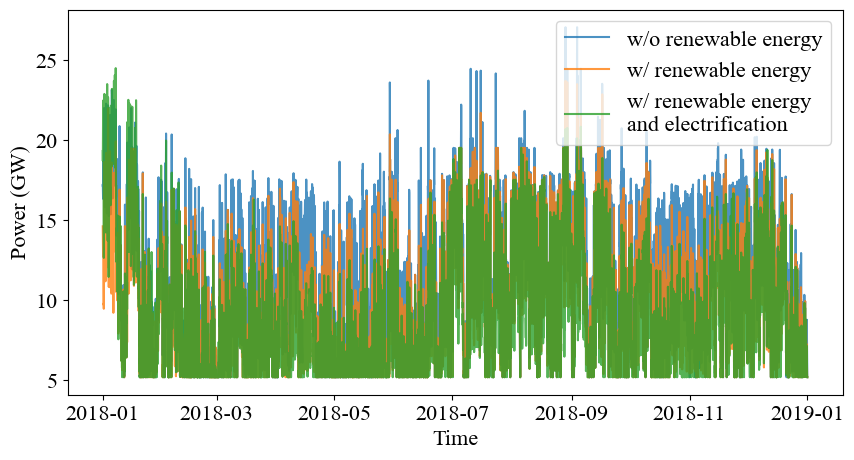

In [24]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(thermal_pg_wo_renew.sum(axis=1)/1e3, alpha=0.8, label='w/o renewable energy')
ax.plot(thermal_pg_w_renew.sum(axis=1)/1e3, alpha=0.8, label='w/ renewable energy')
ax.plot(thermal_pg_w_renew_elec.sum(axis=1)/1e3, alpha=0.8, label='w/ renewable energy\nand electrification')

ax.set_ylabel('Power (GW)', fontsize=16)
ax.set_xlabel('Time', fontsize=16)
ax.legend(fontsize=16)
ax.tick_params(labelsize=16)
fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_year.png'), 
            dpi=600, bbox_inches='tight', format='png')
fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_year.svg'), 
            bbox_inches='tight', format='svg')


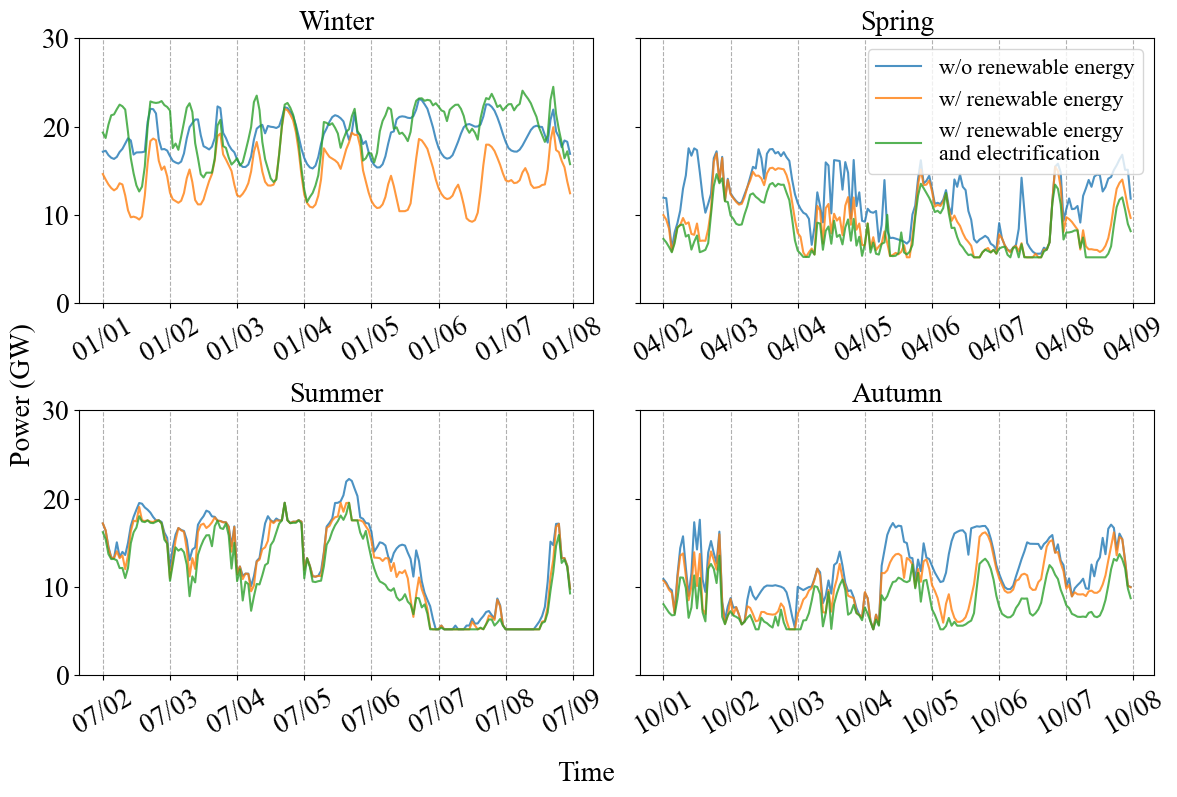

In [93]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8),
                        sharex=False, sharey=True)

for i in range(4):
    ax = axs.flatten()[i]
    
    ax.plot(1/1e3*thermal_pg_wo_renew.sum(axis=1).loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, label='w/o renewable energy')
    ax.plot(1/1e3*thermal_pg_w_renew.sum(axis=1).loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, label='w/ renewable energy')
    ax.plot(1/1e3*thermal_pg_w_renew_elec.sum(axis=1).loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, label='w/ renewable energy\nand electrification')


    # Formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%m/%d'))
    ax.set_ylim(0, 30)
    ax.tick_params(axis='x', rotation=30)
    ax.set_title(season_list[i], fontsize=20)
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=20)
    if i == 1:
            ax.legend(fontsize=16)


fig.supxlabel('Time', fontsize=20)
fig.supylabel('Power (GW)', fontsize=20)
# title = 'Total thermal generation in NYS'
# fig.suptitle(title, fontsize=24)
plt.tight_layout()
fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.png'), 
            dpi=600, bbox_inches='tight', format='png')
fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_rep_weeks.svg'), 
            bbox_inches='tight', format='svg')

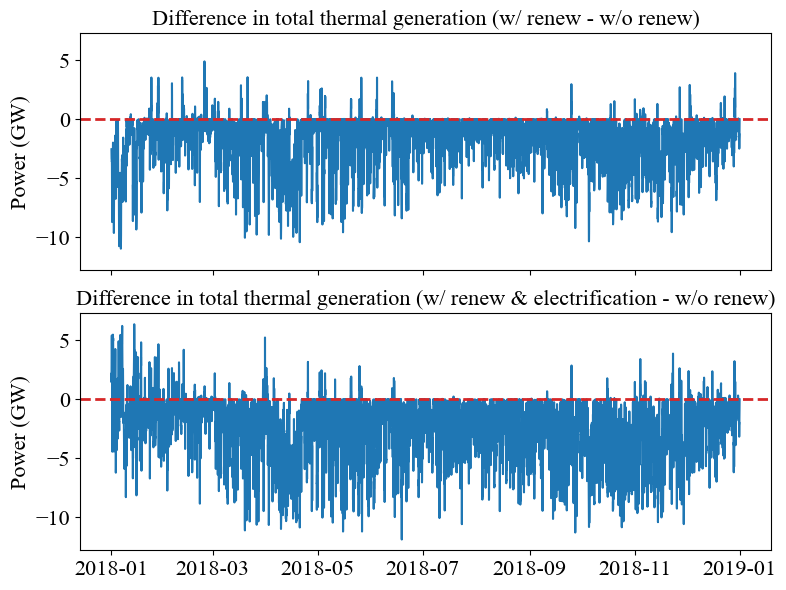

In [25]:
fig, axs = plt.subplots(2, 1, figsize=(8, 6),
                        sharex=True, sharey=True)

thermal_pg_diff_w_renew = thermal_pg_w_renew - thermal_pg_wo_renew
thermal_pg_diff_w_renew_elec = thermal_pg_w_renew_elec - thermal_pg_wo_renew

axs[0].plot(thermal_pg_diff_w_renew.sum(axis=1)/1e3)
axs[1].plot(thermal_pg_diff_w_renew_elec.sum(axis=1)/1e3)

axs[0].set_title('Difference in total thermal generation (w/ renew - w/o renew)', fontsize=16)
axs[1].set_title('Difference in total thermal generation (w/ renew & electrification - w/o renew)', fontsize=16)

for ax in axs:
    ax.set_ylabel('Power (GW)', fontsize=16)
    ax.tick_params(labelsize=16)
    ax.axhline(0, color='tab:red', linestyle='--', linewidth=2)

plt.tight_layout()
fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_diff_year.png'), 
            dpi=600, bbox_inches='tight', format='png')
fig.savefig(os.path.join(fig_dir, f'total_thermal_gen_diff_year.svg'), 
            bbox_inches='tight', format='svg')

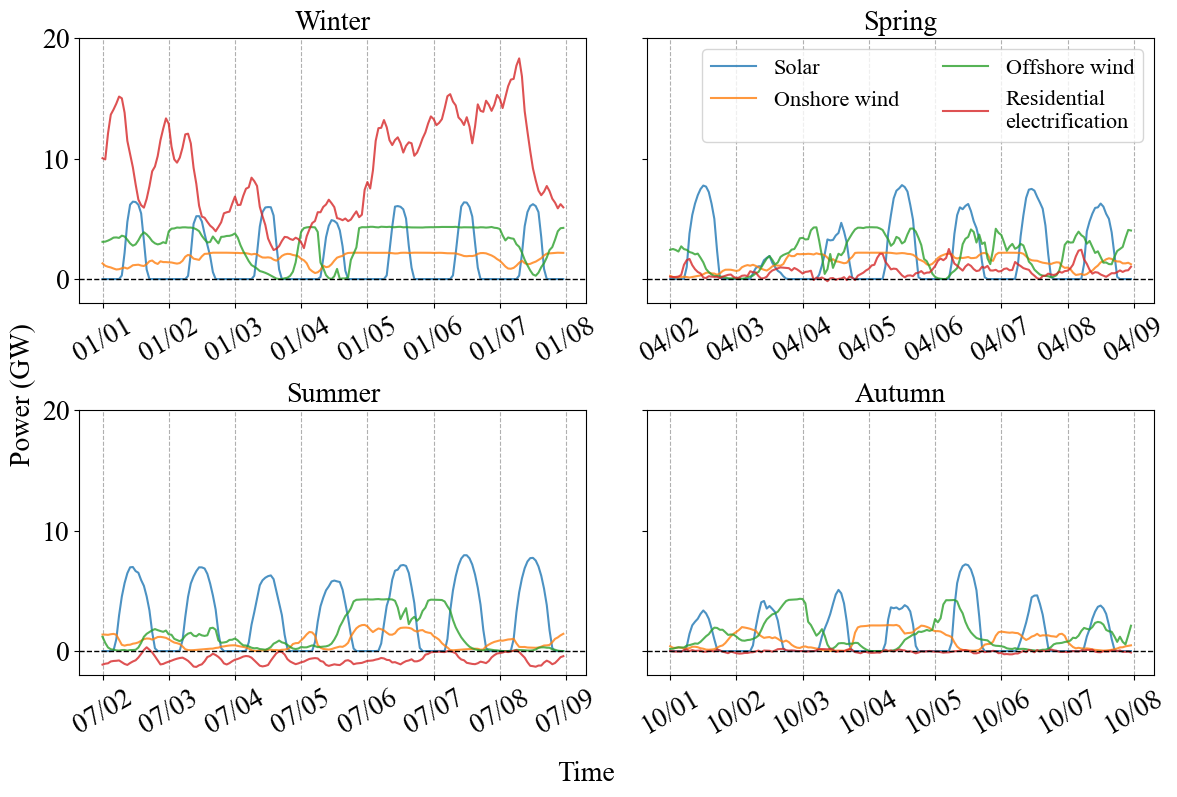

In [96]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8),
                        sharex=False, sharey=True)

for i in range(4):
    ax = axs.flatten()[i]
    
    ax.plot(1/1e3*load_renewable_total['Solar'].loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, label='Solar')
    ax.plot(1/1e3*load_renewable_total['Onshore wind'].loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, label='Onshore wind')
    ax.plot(1/1e3*load_renewable_total['Offshore wind'].loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, label='Offshore wind')
    ax.plot(1/1e6*load_renewable_total['Residential electrification'].loc[week_list[i][0]:week_list[i][1]], 
            alpha=0.8, label='Residential\nelectrification')

    # Formatting
    ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%m/%d'))
    ax.set_ylim(-2, 20)
    ax.tick_params(axis='x', rotation=30)
    ax.set_title(season_list[i], fontsize=20)
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.axhline(0, color='k', linestyle='--', linewidth=1)
    if i == 1:
            ax.legend(fontsize=16, loc='upper right', ncol=2)


fig.supxlabel('Time', fontsize=20)
fig.supylabel('Power (GW)', fontsize=20)
# title = 'Total thermal generation in NYS'
# fig.suptitle(title, fontsize=24)
plt.tight_layout()
fig.savefig(os.path.join(fig_dir, f'total_renewable_gen_rep_weeks.png'), 
            dpi=600, bbox_inches='tight', format='png')
fig.savefig(os.path.join(fig_dir, f'total_renewable_gen_rep_weeks.svg'), 
            bbox_inches='tight', format='svg')

### Individual generators

In [94]:
for ii in range(num_thermal):

    gen_name = gen_info.NYISOName[ii]
    fig, axs = plt.subplots(2, 2, figsize=(12, 8),
                        sharex=False, sharey=True)

    for i in range(4):
        ax = axs.flatten()[i]
        
        ax.plot(thermal_pg_wo_renew.loc[week_list[i][0]:week_list[i][1], gen_name], 
                alpha=0.8, label='w/o renewable energy')
        ax.plot(thermal_pg_w_renew.loc[week_list[i][0]:week_list[i][1], gen_name], 
                alpha=0.8, label='w/ renewable energy')
        ax.plot(thermal_pg_w_renew_elec.loc[week_list[i][0]:week_list[i][1], gen_name], 
                alpha=0.8, label='w/ renewable energy\nand electrification')


        # Formatting
        ax.xaxis.set_major_formatter(mdates.DateFormatter(r'%m/%d'))
        ax.tick_params(axis='x', rotation=30)
        ax.set_title(season_list[i], fontsize=20)
        ax.grid(axis='x', linestyle='--')
        ax.tick_params(axis='both', which='major', labelsize=20)
        if i == 1:
                ax.legend(fontsize=16, loc='upper right')


    fig.supxlabel('Time', fontsize=20)
    fig.supylabel('Power (MW)', fontsize=20)
    title = f'{gen_info.NYISOName[ii]} ({gen_info.UnitType[ii]}, Zone {gen_info.Zone[ii]})'
    fig.suptitle(title, fontsize=24)
    plt.tight_layout()
    gen_name_str = gen_name.replace('/', '_')
    fig.savefig(os.path.join(fig_dir, 'thermal_pg', f'{gen_name_str}.png'), dpi=300)
    plt.close()